In [12]:
import pandas as pd
import pandas_datareader.data as pdr
import datetime
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import numpy as np
import argparse
from copy import deepcopy # Add Deepcopy for args
from sklearn.metrics import mean_absolute_error
import yfinance as yf
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print(torch.__version__)
print(np.__version__)
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 9)

1.13.0
1.26.4
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


c:\Users\dmqa1905\.conda\envs\torch\lib\site-packages\IPython\core\magics\pylab.py:166: UserWarning: pylab import has clobbered these variables: ['partition', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [13]:
# We will look at stock prices over the past year, starting at January 1, 2016
start = (2000, 12, 1)
start = datetime.datetime(*start)
end = datetime.date.today()
google = yf.download('028050.KS', start=start, end=end)

if isinstance(google.columns, pd.MultiIndex):
    google.columns = google.columns.get_level_values(0)

print(google.head())
print(google.columns)
print(google.isna().sum())

[*********************100%***********************]  1 of 1 completed

Price             Close         High          Low         Open  Volume
Date                                                                  
2000-12-01  1851.257568  1851.257568  1792.017326  1847.555053  222800
2000-12-04  1829.042236  1895.687500  1814.232178  1851.257324  196100
2000-12-05  1840.149658  1851.257201  1817.934572  1817.934572  158800
2000-12-06  1843.852417  1910.497685  1843.852417  1873.472536  287600
2000-12-07  1825.339844  1843.852418  1817.934814  1829.042359  147900
Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64


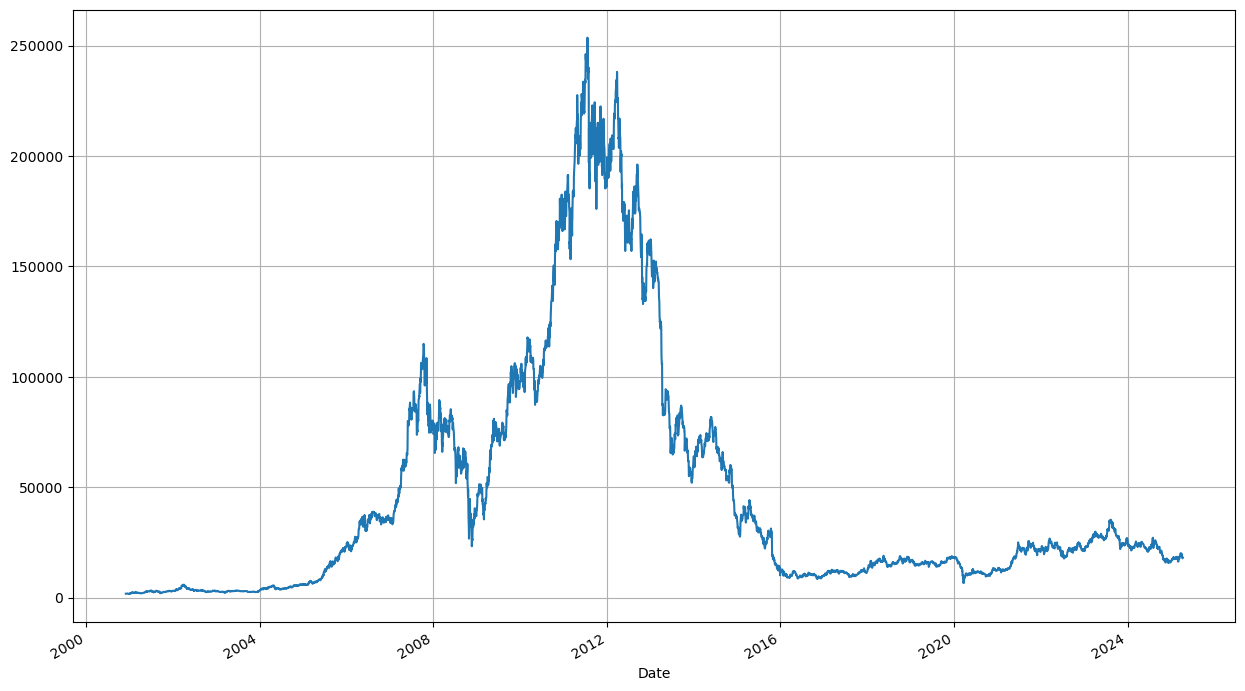

In [14]:
google.Low.plot(grid=True)
print(google.isna().sum())

In [15]:
# Dataset : i번째 record 값을 주는 역할
# x_frames : 최근 n일
# y_frames : 이후 n일
class StockDataset(Dataset):
    
    def __init__(self, symbol, x_frames, y_frames, start, end):
        
        self.symbol = symbol
        self.x_frames = x_frames
        self.y_frames = y_frames
        
        self.start = datetime.datetime(*start)
        self.end = datetime.datetime(*end)

        #data
        google = yf.download('028050.KS', start=self.start, end=self.end)
        if isinstance(google.columns, pd.MultiIndex):
            google.columns = google.columns.get_level_values(0)
        self.data = google
        print(self.data.isna().sum())
    
    # 생성할 수 있는 Seq 개수
    def __len__(self):
        return len(self.data) - (self.x_frames + self.y_frames) + 1
    
    #i번째 데이터 요청이 왔을 때 i번째 데이터를 불러오는 역할
    def __getitem__(self, idx):
        idx += self.x_frames
        # idx 기준 이전 x개, 이후 y개
        data = self.data.iloc[idx-self.x_frames:idx+self.y_frames]
        data = data[['High', 'Low', 'Open', 'Close','Volume']]
        # (log(x+1) - log(x_ref+1)): 기준 시점(x_frames-1) 대비 변화율을 의미.
        data = data.apply(lambda x: np.log(x+1) - np.log(x[self.x_frames-1]+1))
        # numpy.ndarray로 변환
        data = data.values
        X = data[:self.x_frames] # 자른 앞쪽 : X
        y = data[self.x_frames:] # 자른 뒤쪽 : y
        
        return X, y

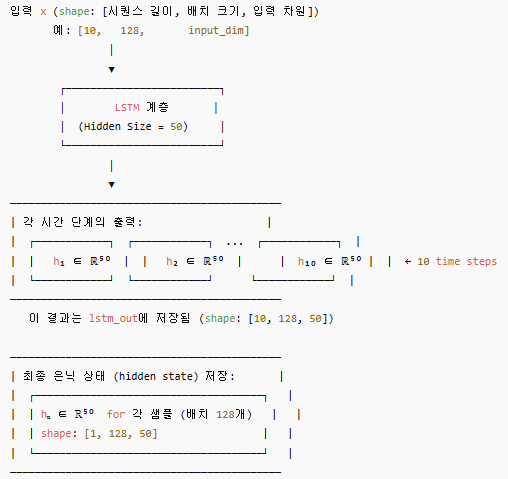

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, batch_size, dropout, use_bn):
        super(LSTM, self).__init__()
        self.input_dim = input_dim 
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers

        self.batch_size = batch_size
        self.dropout = dropout
        self.use_bn = use_bn 
        
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        self.hidden = self.init_hidden()
        self.regressor = self.make_regressor()
        
    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
    
    def make_regressor(self):
        layers = []
        if self.use_bn:
            layers.append(nn.BatchNorm1d(self.hidden_dim))
        layers.append(nn.Dropout(self.dropout))
        
        layers.append(nn.Linear(self.hidden_dim, self.hidden_dim // 2))
        layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_dim // 2, self.output_dim))
        regressor = nn.Sequential(*layers)
        return regressor
    
    def forward(self, x):
        print('x', x.shape)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        print('output', lstm_out.shape, self.hidden[0].shape, self.hidden[1].shape)
        # lstm_out[-1] 마지막 출력값
        y_pred = self.regressor(lstm_out[-1].view(self.batch_size, -1))
        print('pred', y_pred.shape)
        return y_pred
    
    # x : torch.Size([10, 128, 5]) / [x_frames, batch_size, input_dim]
    # output : torch.Size([10, 128, 50]) torch.Size([1, 128, 50]) torch.Size([1, 128, 50]) / 50 = hid_dim
    # pred : torch.Size([128, 5])

    # lstm_out: 전체 시퀀스에 대한 LSTM의 출력
    # self.hidden: LSTM의 내부 상태를 담은 튜플로, (hidden state, cell state)를 의미
    
    # self.hidden[0] (hidden state, hₙ) 의미
    # LSTM에서 hidden state는 각 시퀀스 데이터의 마지막 시간 단계에서 계산된 은닉 상태
    # 시퀀스가 모두 처리된 후 모델이 기억하고 있는 정보를 담고 있으며, 
    # 후속 연산(예를 들어, 예측을 위한 Fully Connected layer 입력)으로 사용
    # 1 = 레이어 수와 방향 의미. 단일 레이어 & 단방향이므로 1
    # self.hidden[1] (cell state, cₙ)

In [17]:
def metric(y_pred, y_true):
    perc_y_pred = np.exp(y_pred.cpu().detach().numpy())
    perc_y_true = np.exp(y_true.cpu().detach().numpy())
    mae = mean_absolute_error(perc_y_true, perc_y_pred, multioutput='raw_values')
    return mae*100

In [ ]:
def train(model, partition, optimizer, loss_fn, args):
    trainloader = DataLoader(partition['train'],
                             batch_size=args.batch_size,
                             shuffle=True,
                             drop_last=True)
    
    model.train()
    model.zero_grad()
    optimizer.zero_grad()
    
    train_acc = 0.0
    train_loss = 0.0

    for i, (X,y) in enumerate(trainloader):

        # x : (sequence_length, batch_size, input_dim) 최근 n일
        # y : [batch_size(10), m, 1] 이후 m일 
        X = X.transpose(0, 1).float().to(args.device)
        y_true = y[:, :, 3].float().to(args.device)
        #print(torch.max(X[:, :, 3]), torch.max(y_true))

        model.zero_grad()
        optimizer.zero_grad()
        model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

        y_pred = model(X)
        loss = loss_fn(y_pred.view(-1), y_true.view(-1))
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += metric(y_pred, y_true)[0]

    train_loss = train_loss / len(trainloader)
    train_acc = train_acc / len(trainloader)
    return model, train_loss, train_acc    

In [19]:
def validate(model, partition, loss_fn, args):
    valloader = DataLoader(partition['val'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    val_acc = 0.0
    val_loss = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(valloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            loss = loss_fn(y_pred.view(-1), y_true.view(-1))

            val_loss += loss.item()
            val_acc += metric(y_pred, y_true)[0]

    val_loss = val_loss / len(valloader)
    val_acc = val_acc / len(valloader)
    return val_loss, val_acc

In [20]:
def test(model, partition, args):
    testloader = DataLoader(partition['test'], 
                           batch_size=args.batch_size, 
                           shuffle=False, drop_last=True)
    model.eval()

    test_acc = 0.0
    with torch.no_grad():
        for i, (X, y) in enumerate(testloader):

            X = X.transpose(0, 1).float().to(args.device)
            y_true = y[:, :, 3].float().to(args.device)
            model.hidden = [hidden.to(args.device) for hidden in model.init_hidden()]

            y_pred = model(X)
            test_acc += metric(y_pred, y_true)[0]

    test_acc = test_acc / len(testloader)
    return test_acc

In [27]:
def experiment(partition, args):

    model = LSTM(args.input_dim, args.hid_dim, args.y_frames, args.n_layers, args.batch_size, args.dropout, args.use_bn)
    model.to(args.device)
    loss_fn = torch.nn.MSELoss()

    loss_fn = nn.MSELoss()
    if args.optim == 'SGD':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else:
        raise ValueError('In-valid optimizer choice')
    
    # ===== List for epoch-wise data ====== #
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    # ===================================== #
        
    for epoch in range(args.epoch):  # loop over the dataset multiple times
        ts = time.time()
        model, train_loss, train_acc = train(model, partition, optimizer, loss_fn, args)
        val_loss, val_acc = validate(model, partition, loss_fn, args)
        te = time.time()
        
        # ====== Add Epoch Data ====== #
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        # ============================ #
        
        print('Epoch {}, Acc(train/val): {:2.2f}/{:2.2f}, Loss(train/val) {:2.5f}/{:2.5f}. Took {:2.2f} sec'.format(epoch, train_acc, val_acc, train_loss, val_loss, te-ts))
        
    test_acc = test(model, partition, args)    
    
    # ======= Add Result to Dictionary ======= #
    result = {}
    result['train_losses'] = train_losses
    result['val_losses'] = val_losses
    result['train_accs'] = train_accs
    result['val_accs'] = val_accs
    result['train_acc'] = train_acc
    result['val_acc'] = val_acc
    result['test_acc'] = test_acc
    return vars(args), result

In [28]:
import hashlib
import json
from os import listdir
from os.path import isfile, join
import pandas as pd

def save_exp_result(setting, result):
    exp_name = setting['exp_name']
    del setting['epoch']

    hash_key = hashlib.sha1(str(setting).encode()).hexdigest()[:6]
    filename = './results/{}-{}.json'.format(exp_name, hash_key)
    result.update(setting)
    with open(filename, 'w') as f:
        json.dump(result, f)

    
def load_exp_result(exp_name):
    dir_path = './results'
    filenames = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) if '.json' in f]
    list_result = []
    for filename in filenames:
        if exp_name in filename:
            with open(join(dir_path, filename), 'r') as infile:
                results = json.load(infile)
                list_result.append(results)
    df = pd.DataFrame(list_result) # .drop(columns=[])
    return df

In [29]:
def plot_acc(var1, var2, df):

    fig, ax = plt.subplots(1, 3)
    fig.set_size_inches(15, 6)
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})

    sns.barplot(x=var1, y='train_acc', hue=var2, data=df, ax=ax[0])
    sns.barplot(x=var1, y='val_acc', hue=var2, data=df, ax=ax[1])
    sns.barplot(x=var1, y='test_acc', hue=var2, data=df, ax=ax[2])
    
    ax[0].set_title('Train Accuracy')
    ax[1].set_title('Validation Accuracy')
    ax[2].set_title('Test Accuracy')

    
def plot_loss_variation(var1, var2, df, **kwargs):

    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_losses = list(row.train_losses)[0]
            val_losses = list(row.val_losses)[0]

            for epoch, train_loss in enumerate(train_losses):
                list_data.append({'type':'train', 'loss':train_loss, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_loss in enumerate(val_losses):
                list_data.append({'type':'val', 'loss':val_loss, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'loss', marker='.')
    g.add_legend()
    g.fig.suptitle('Train loss vs Val loss')
    plt.subplots_adjust(top=0.89) # 만약 Title이 그래프랑 겹친다면 top 값을 조정해주면 됩니다! 함수 인자로 받으면 그래프마다 조절할 수 있겠죠?


def plot_acc_variation(var1, var2, df, **kwargs):
    list_v1 = df[var1].unique()
    list_v2 = df[var2].unique()
    list_data = []

    for value1 in list_v1:
        for value2 in list_v2:
            row = df.loc[df[var1]==value1]
            row = row.loc[df[var2]==value2]

            train_accs = list(row.train_accs)[0]
            val_accs = list(row.val_accs)[0]
            test_acc = list(row.test_acc)[0]

            for epoch, train_acc in enumerate(train_accs):
                list_data.append({'type':'train', 'Acc':train_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})
            for epoch, val_acc in enumerate(val_accs):
                list_data.append({'type':'val', 'Acc':val_acc, 'test_acc':test_acc, 'epoch':epoch, var1:value1, var2:value2})

    df = pd.DataFrame(list_data)
    g = sns.FacetGrid(df, row=var2, col=var1, hue='type', **kwargs)
    g = g.map(plt.plot, 'epoch', 'Acc', marker='.')

    def show_acc(x, y, metric, **kwargs):
        plt.scatter(x, y, alpha=0.3, s=1)
        metric = "Test Acc: {:1.3f}".format(list(metric.values)[0])
        plt.text(0.05, 0.95, metric,  horizontalalignment='left', verticalalignment='center', transform=plt.gca().transAxes, bbox=dict(facecolor='yellow', alpha=0.5, boxstyle="round,pad=0.1"))
    g = g.map(show_acc, 'epoch', 'Acc', 'test_acc')

    g.add_legend()
    g.fig.suptitle('Train Accuracy vs Val Accuracy')
    plt.subplots_adjust(top=0.89)

In [34]:
# ====== Random Seed Initialization ====== #
seed = 666
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = "exp1_lr"
args.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# ====== Data Loading ====== #
args.symbol = '028050.KS'
args.batch_size = 128
args.x_frames = 10
args.y_frames = 5

# ====== Model Capacity ===== #
args.input_dim = 5
args.hid_dim = 50
args.n_layers = 2

# ====== Regularization ======= #
args.l2 = 0.00001
args.dropout = 0.0
args.use_bn = True

# ====== Optimizer & Training ====== #
args.optim = 'RMSprop' #'RMSprop' #SGD, RMSprop, ADAM...
args.lr = 0.0001
args.epoch = 2


# ====== Experiment Variable ====== #
name_var1 = 'lr'
name_var2 = 'n_layers'
list_var1 = [0.001, 0.0001, 0.00001]
list_var2 = [1,2,3]

trainset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2000,1,1), (2012,1,1))
valset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2012,1,1), (2016,1,1))
testset = StockDataset(args.symbol, args.x_frames, args.y_frames, (2016,1,1), (2019,2,1))
partition = {'train': trainset, 'val':valset, 'test':testset}

for var1 in list_var1:
    for var2 in list_var2:
        setattr(args, name_var1, var1)
        setattr(args, name_var2, var2)
        print(args)
                
        setting, result = experiment(partition, deepcopy(args))
        save_exp_result(setting, result)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
Price
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64
Namespace(exp_name='exp1_lr', device='cuda', symbol='028050.KS', batch_size=128, x_frames=10, y_frames=5, input_dim=5, hid_dim=50, n_layers=1, l2=1e-05, dropout=0.0, use_bn=True, optim='RMSprop', lr=0.001, epoch=2)
x torch.Size([10, 128, 5])
output torch.Size([10, 128, 50]) torch.Size([1, 128, 50]) torch.Size([1, 128, 50])
pred torch.Size([128, 5])
x torch.Size([10, 128, 5])
output torch.Size([10, 128, 50]) torch.Size([1, 128, 50]) torch.Size([1, 128, 50])
pred torch.Size([128, 5])
x torch.Size([10, 128, 5])
output torch.Size([10, 128, 50]) torch.Size([1, 128, 50]) torch.Size([1, 128, 50])
pred torch.Size([128, 5])
x torch.Size([10, 128, 5])
output torch.Size([10, 128, 50]) torch.Size([1, 128, 50]) torch.Size([1, 128, 50])
pred torch.Size([128, 5])
x to

KeyboardInterrupt: 